# SimCLR
PyTorch implementation of SimCLR: A Simple Framework for Contrastive Learning of Visual Representations by T. Chen et al. With support for the LARS (Layer-wise Adaptive Rate Scaling) optimizer and global batch norm.

[Link to paper](https://arxiv.org/pdf/2002.05709.pdf)


## Setup the repository

In [5]:
! pip install tqdm

     |████████████████████████████████| 71kB 2.2MB/s eta 0:00:011
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
! pip install Bottleneck==1.2.1

In [6]:
! pip install fastai

  Using cached https://files.pythonhosted.org/packages/54/12/f965e8529658c109ec710e77c843227b1acecfc0d3b22f5082b330b78e3a/fastai-1.0.61-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e1/d2/6f02df2616fd4016075f60157c7a0452b38d8f7938ae94343911e0fb0b09/dataclasses-0.7-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a3/da/ffd8fe0daf7e679804a32a1e8654ac2988e2ef85937fc1d223e98eee736e/fastprogress-0.2.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/31/c7/e66e2af1cfa418c3a3917c116c4e00ccffa546f18f59e6acd7953d833c5c/spacy-2.3.0-cp36-cp36m-manylinux1_x86_64.whl
     |████████████████████████████████| 25.9MB 12.3MB/s eta 0:00:01     |██████████████████████████████▉ | 24.9MB 12.3MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/6d/64/cce82bddb80c0b0f5c703bbdafa94bfb69a1c5ad7a79cff00b482468f0d3/nvidia-ml-py3-7.352.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/c0/95/cb9820560a2713384ef4

  Created wheel for wasabi: filename=wasabi-0.7.0-cp36-none-any.whl size=26106 sha256=9a38afbe041ee45467320fba891aac10985a66aed09bc38f55ade558272024b3
  Stored in directory: /root/.cache/pip/wheels/33/96/74/01741d5dde3d866a4461a05b3fc6aa43bd7ece8729a7264bf7
Successfully built nvidia-ml-py3 wasabi
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
# ! wget -q https://storage.googleapis.com/crowdstf-rico-uiuc-4540/rico_dataset_v0.1/unique_uis.tar.gz -P /tf/data
# ! tar -xzf /tf/data/unique_uis.tar.gz
# ! mkdir combined/data
# ! mv combined/*.jpg combined/data

# ! git clone --quiet https://github.com/spijkervet/SimCLR.git /tf/data/SimCLR
%cd /tf/data/SimCLR
# ! eval "$(/root/miniconda3/bin/conda shell.bash hook)" && sh setup.sh || pip install -q -r requirements.txt || exit 1
# ! pip install -q -r requirements.txt || exit 1
# ! pip install -q pyyaml --upgrade

/tf/data/SimCLR


# Part 1:
## SimCLR pre-training

In [2]:
# whether to use a TPU or not (set in Runtime -> Change Runtime Type)
use_tpu = False

#### Install PyTorch/XLA

In [3]:
if use_tpu:
  VERSION = "20200220" #@param ["20200220","nightly", "xrt==1.15.0"]
  !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
  !python pytorch-xla-env-setup.py --version $VERSION

In [4]:
import os
import torch

if use_tpu:
  # imports the torch_xla package for TPU support
  import torch_xla
  import torch_xla.core.xla_model as xm
  dev = xm.xla_device()
  print(dev)
  
import torchvision
import argparse

from torch.utils.tensorboard import SummaryWriter

apex = False
try:
    from apex import amp
    apex = True
except ImportError:
    print(
        "Install the apex package from https://www.github.com/nvidia/apex to use fp16 for training"
    )

from model import load_model, save_model
from modules import NT_Xent
from modules.transformations import TransformsSimCLR
from utils import post_config_hook

from tqdm.auto import tqdm

Install the apex package from https://www.github.com/nvidia/apex to use fp16 for training


In [5]:
def train(args, train_loader, model, criterion, optimizer, writer):
    loss_epoch = 0
    for step, ((x_i, x_j), _) in tqdm(enumerate(train_loader), total = len(train_loader)):

        optimizer.zero_grad()
        x_i = x_i.to(args.device)
        x_j = x_j.to(args.device)

        # positive pair, with encoding
        h_i, z_i = model(x_i)
        h_j, z_j = model(x_j)

        loss = criterion(z_i, z_j)

        if apex and args.fp16:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()

        optimizer.step()

        if step % 50 == 0:
            print(f"Step [{step}/{len(train_loader)}]\t Loss: {loss.item()}")

        writer.add_scalar("Loss/train_epoch", loss.item(), args.global_step)
        loss_epoch += loss.item()
        args.global_step += 1

    return loss_epoch

### Load arguments from `config/config.yaml`

In [6]:
from pprint import pprint
from utils.yaml_config_hook import yaml_config_hook

config = yaml_config_hook("./config/config.yaml")
args = argparse.Namespace(**config)

if use_tpu:
  args.device = dev
else:
  args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  
args.out_dir = "logs"
if not os.path.exists("logs"):
  os.makedirs("logs")

In [7]:
### override any configuration parameters here, e.g. to adjust for use on GPUs on the Colab platform:
args.batch_size = 48
args.resnet = "resnet50"
args.dataset = "RICO"
args.epoch_num = 20
args.epochs = 20
pprint(vars(args))

{'batch_size': 48,
 'dataset': 'RICO',
 'device': device(type='cuda', index=0),
 'epoch_num': 20,
 'epochs': 20,
 'fp16': False,
 'fp16_opt_level': 'O2',
 'logistic_batch_size': 256,
 'logistic_epochs': 500,
 'model_path': 'logs/0',
 'normalize': True,
 'optimizer': 'Adam',
 'out_dir': 'logs',
 'pretrain': True,
 'projection_dim': 64,
 'resnet': 'resnet50',
 'seed': 42,
 'start_epoch': 0,
 'temperature': 0.5,
 'weight_decay': 1e-06,
 'workers': 16}


### Load dataset into train loader

In [14]:
root = "./datasets"

train_sampler = None

if args.dataset == "STL10":
    train_dataset = torchvision.datasets.STL10(
        root, split="unlabeled", download=True, transform=TransformsSimCLR(size=96) # 224 in the original paper
    )
elif args.dataset == "CIFAR10":
    train_dataset = torchvision.datasets.CIFAR10(
        root, download=True, transform=TransformsSimCLR(size=32) # 224 in the original paper
    )
elif args.dataset == "RICO":
    train_dataset = torchvision.datasets.ImageFolder('/tf/data/combined',
                                                     transform=TransformsSimCLR(size=(224, 224)))
else:
    raise NotImplementedError

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=(train_sampler is None),
    drop_last=True,
    num_workers=args.workers,
    sampler=train_sampler,
)

### Load the SimCLR model, optimizer and learning rate scheduler

In [9]:
model, optimizer, scheduler = load_model(args, train_loader)

### Setup TensorBoard for logging experiments

In [9]:
tb_dir = os.path.join(args.out_dir, "colab")
if not os.path.exists(tb_dir):
  os.makedirs(tb_dir)
writer = SummaryWriter(log_dir=tb_dir)

### Create the mask that will remove correlated samples from the negative examples

### Initialize the criterion (NT-Xent loss)

In [8]:
criterion = NT_Xent(args.batch_size, args.temperature, args.device)

### Start training

In [ ]:
args.global_step = 0
args.current_epoch = 0
for epoch in tqdm(range(args.start_epoch, args.epochs)):
    lr = optimizer.param_groups[0]['lr']
    loss_epoch = train(args, train_loader, model, criterion, optimizer, writer)

    if scheduler:
        scheduler.step()

    if epoch % 5 == 0:
        save_model(args, model, optimizer)

    writer.add_scalar("Loss/train", loss_epoch / len(train_loader), epoch)
    writer.add_scalar("Misc/learning_rate", lr, epoch)
    print(
        f"Epoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(train_loader)}\t lr: {round(lr, 5)}"
    )
    args.current_epoch += 1

## end training
save_model(args, model, optimizer)

Step [0/1380]	 Loss: 4.5306196212768555
Step [50/1380]	 Loss: 4.322466850280762
Step [100/1380]	 Loss: 4.17362117767334
Step [150/1380]	 Loss: 4.345911979675293
Step [200/1380]	 Loss: 4.350034236907959
Step [250/1380]	 Loss: 4.282359600067139
Step [300/1380]	 Loss: 4.041628837585449
Step [350/1380]	 Loss: 4.196516990661621
Step [400/1380]	 Loss: 3.972646474838257
Step [450/1380]	 Loss: 4.225488662719727
Step [500/1380]	 Loss: 4.264658451080322
Step [550/1380]	 Loss: 3.927827835083008
Step [600/1380]	 Loss: 4.315315246582031
Step [650/1380]	 Loss: 4.027143478393555
Step [700/1380]	 Loss: 4.100259780883789
Step [750/1380]	 Loss: 3.9259390830993652
Step [800/1380]	 Loss: 3.8987538814544678
Step [850/1380]	 Loss: 3.7415387630462646
Step [900/1380]	 Loss: 3.6825809478759766
Step [950/1380]	 Loss: 3.8239428997039795
Step [1000/1380]	 Loss: 3.804898977279663
Step [1050/1380]	 Loss: 3.69191312789917
Step [1100/1380]	 Loss: 3.8343100547790527
Step [1150/1380]	 Loss: 3.699005603790283
Step [1200

Step [0/1380]	 Loss: 3.586041212081909
Step [50/1380]	 Loss: 3.6044979095458984
Step [100/1380]	 Loss: 3.7800910472869873
Step [150/1380]	 Loss: 3.749504566192627
Step [200/1380]	 Loss: 3.742903232574463
Step [250/1380]	 Loss: 3.6443450450897217
Step [300/1380]	 Loss: 3.5227389335632324
Step [350/1380]	 Loss: 3.658529043197632
Step [400/1380]	 Loss: 3.6761529445648193
Step [450/1380]	 Loss: 3.566431760787964
Step [500/1380]	 Loss: 3.5148181915283203
Step [550/1380]	 Loss: 3.565946102142334
Step [600/1380]	 Loss: 3.545431137084961
Step [650/1380]	 Loss: 3.5909974575042725
Step [700/1380]	 Loss: 3.546322822570801
Step [750/1380]	 Loss: 3.488753318786621
Step [800/1380]	 Loss: 3.544407606124878
Step [850/1380]	 Loss: 3.6668384075164795
Step [900/1380]	 Loss: 3.574758291244507
Step [950/1380]	 Loss: 3.3882808685302734
Step [1000/1380]	 Loss: 3.6108317375183105
Step [1050/1380]	 Loss: 3.497669219970703
Step [1100/1380]	 Loss: 3.4306116104125977
Step [1150/1380]	 Loss: 3.581998586654663
Step

Step [0/1380]	 Loss: 3.531208038330078
Step [50/1380]	 Loss: 3.520561933517456
Step [100/1380]	 Loss: 3.4913346767425537
Step [150/1380]	 Loss: 3.4799773693084717
Step [200/1380]	 Loss: 3.5021495819091797
Step [250/1380]	 Loss: 3.398785352706909
Step [300/1380]	 Loss: 3.448788642883301
Step [350/1380]	 Loss: 3.5266804695129395
Step [400/1380]	 Loss: 3.469223737716675
Step [450/1380]	 Loss: 3.4245831966400146
Step [500/1380]	 Loss: 3.4820470809936523
Step [550/1380]	 Loss: 3.395695686340332
Step [600/1380]	 Loss: 3.4521281719207764
Step [650/1380]	 Loss: 3.375269889831543
Step [700/1380]	 Loss: 3.327467679977417
Step [750/1380]	 Loss: 3.3765456676483154
Step [800/1380]	 Loss: 3.4366159439086914
Step [850/1380]	 Loss: 3.4807329177856445
Step [900/1380]	 Loss: 3.474806308746338
Step [950/1380]	 Loss: 3.3842484951019287
Step [1000/1380]	 Loss: 3.540546417236328
Step [1050/1380]	 Loss: 3.2788808345794678
Step [1100/1380]	 Loss: 3.414031982421875
Step [1150/1380]	 Loss: 3.4967458248138428
St

Step [0/1380]	 Loss: 3.5925049781799316
Step [50/1380]	 Loss: 3.490091323852539
Step [100/1380]	 Loss: 3.5423178672790527
Step [150/1380]	 Loss: 3.416807174682617
Step [200/1380]	 Loss: 3.351696491241455
Step [250/1380]	 Loss: 3.294354200363159
Step [300/1380]	 Loss: 3.361626625061035


In [10]:
from torch import nn
from fastai.vision import *

class Hook():
    def __init__(self, m:nn.Module, hook_func:HookFunc, is_forward:bool=True, detach:bool=True):
        self.hook_func,self.detach,self.stored = hook_func,detach,None
        f = m.register_forward_hook if is_forward else m.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False

    def hook_fn(self, module:nn.Module, input:Tensors, output:Tensors):
        if self.detach:
            input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
            output = (o.detach() for o in output) if is_listy(output) else output.detach()
        self.stored = self.hook_func(module, input, output)

    def remove(self):
        if not self.removed:
            self.hook.remove()
            self.removed=True

    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
        
def get_output(module, input_value, output):
    return output.flatten(1)

def get_input(module, input_value, output):
    return list(input_value)[0]

def get_named_module_from_model(model, name):
    for n, m in model.named_modules():
        if n == name:
            return m
    return None

In [17]:
transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(size=(224, 224)), torchvision.transforms.ToTensor()])
val_dataset = torchvision.datasets.ImageFolder('/tf/data/combined', transform=transforms)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=48,#args.batch_size,
    shuffle=None,
    drop_last=True,
    num_workers=args.workers,
    sampler=None,
)

In [18]:
args.model_path = "/tf/data/SimCLR/logs"
# args.epoch_num = 5
pprint(vars(args))
# /content/SimCLR/logs/checkpoint_0.tar

{'batch_size': 48,
 'dataset': 'RICO',
 'device': device(type='cuda', index=0),
 'epoch_num': 20,
 'epochs': 20,
 'fp16': False,
 'fp16_opt_level': 'O2',
 'logistic_batch_size': 256,
 'logistic_epochs': 500,
 'model_path': '/tf/data/SimCLR/logs',
 'normalize': True,
 'optimizer': 'Adam',
 'out_dir': 'logs',
 'pretrain': True,
 'projection_dim': 64,
 'resnet': 'resnet50',
 'seed': 42,
 'start_epoch': 0,
 'temperature': 0.5,
 'weight_decay': 1e-06,
 'workers': 16}


In [19]:
simclr_model, _, _ = load_model(args, train_loader, reload_model=True)
simclr_model = simclr_model#.to('cpu')
linear_output_layer = get_named_module_from_model(simclr_model, 'encoder.fc')

In [20]:
import time
img_repr_map = {}

with Hook(linear_output_layer, get_output, True, True) as hook:
    start = time.time()
    try:
        for i, (xb, yb) in enumerate(val_loader):
            bs = args.batch_size
            xb = xb.to('cuda')
            img_ids = val_loader.dataset.samples[i*bs: (i+1)*bs] # val_loader.items[i*bs: (i+1)*bs]
            result = simclr_model.eval()(xb)
            img_reprs = hook.stored.cpu().numpy()
            img_reprs = img_reprs.reshape(bs, -1)
            for img_id, img_repr in zip(img_ids, img_reprs):
                img_repr_map[img_id] = img_repr
            if(len(img_repr_map) % 12800 == 0):
                end = time.time()
                print(f'{end-start} secs for 12800 images')
                start = end
    except Exception as e: print(e)
            
img_repr_df = pd.DataFrame(img_repr_map.items(), columns=['img_id', 'img_repr'])
img_repr_df.head()

518.9488339424133 secs for 12800 images


,img_id,img_repr
0,"(/tf/data/combined/data/0.jpg, 0)","[0.2961652, 0.19250998, 0.49577212, 1.8609074,..."
1,"(/tf/data/combined/data/1.jpg, 0)","[0.68238205, 0.7503681, 0.0998953, 0.5931631, ..."
2,"(/tf/data/combined/data/10.jpg, 0)","[0.20424315, 1.0434297, 0.11513982, 0.585985, ..."
3,"(/tf/data/combined/data/100.jpg, 0)","[0.7302281, 0.42156175, 0.090188615, 0.3758246..."
4,"(/tf/data/combined/data/1000.jpg, 0)","[1.7208669, 0.17701413, 0.2507482, 0.08288158,..."


In [21]:
len(img_repr_df)

66240

In [22]:
from scipy.spatial.distance import cosine

def get_similar_images(img_index, n=10):
    start = time.time()
    # print(img_repr_df.iloc[img_index])
    base_img_id, base_vector = img_repr_df.iloc[img_index].img_id, img_repr_df.iloc[img_index].img_repr
    # print(base_vector)
    cosine_similarity = 1 - img_repr_df['img_repr'].apply(lambda x: cosine(x, base_vector))
    # print(cosine_similarity)
    similar_img_ids = np.argsort(cosine_similarity)[-11:-1][::-1]
    end = time.time()
    print(f'{end - start} secs')
    return base_img_id, img_repr_df.iloc[similar_img_ids]

def show_similar_images(similar_images_df):
    images = [open_image(img_id[0]) for img_id in similar_images_df['img_id']]
    # categories = [learn.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return images

In [35]:
base_image, similar_images_df = get_similar_images(20)
images = show_similar_images(similar_images_df)

3.8230299949645996 secs


In [36]:
from IPython.display import display

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


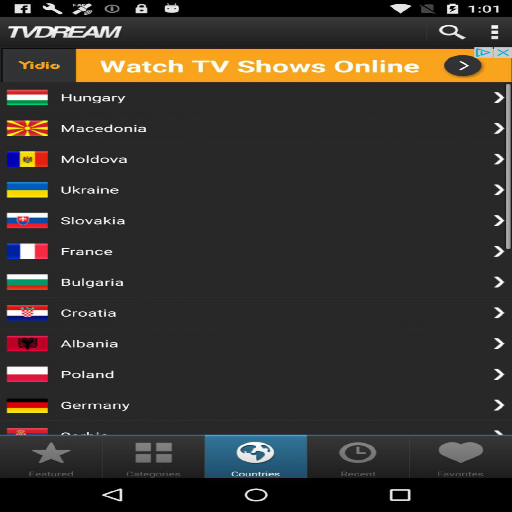

In [37]:
open_image(base_image[0]).resize(512)

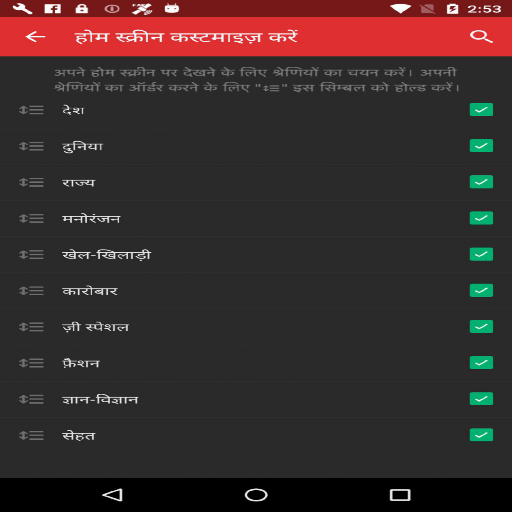

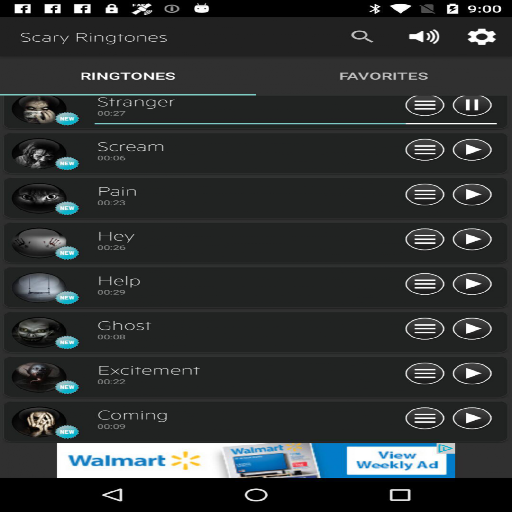

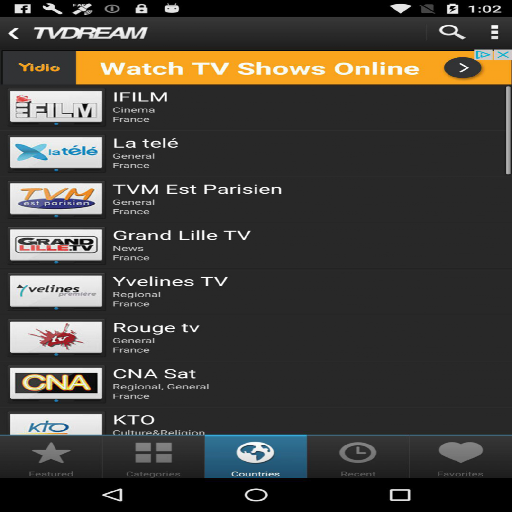

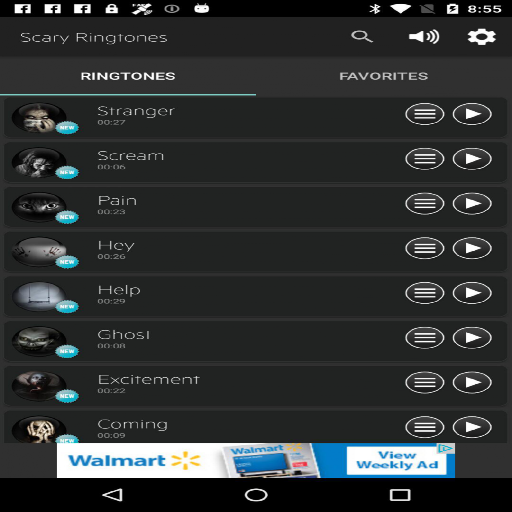

In [38]:
display(images[0].resize(512), images[1].resize(512), images[2].resize(512), images[3].resize(512))

## OPTIONAL: Download last checkpoint to local drive (replace `100` with `args.epochs`)

In [ ]:
from google.colab import files
files.download('./logs/checkpoint_100.tar')

KeyboardInterrupt: ignored

# Part 2:
## Linear evaluation using logistic regression, using weights from frozen, pre-trained SimCLR model

In [ ]:
import torch
import torchvision
import numpy as np
import argparse

from experiment import ex
from model import load_model
from utils import post_config_hook

from modules import LogisticRegression


In [ ]:
def train(args, loader, simclr_model, model, criterion, optimizer):
    loss_epoch = 0
    accuracy_epoch = 0
    for step, (x, y) in enumerate(loader):
        optimizer.zero_grad()

        x = x.to(args.device)
        y = y.to(args.device)

        output = model(x)
        loss = criterion(output, y)

        predicted = output.argmax(1)
        acc = (predicted == y).sum().item() / y.size(0)
        accuracy_epoch += acc

        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        # if step % 100 == 0:
        #     print(
        #         f"Step [{step}/{len(loader)}]\t Loss: {loss.item()}\t Accuracy: {acc}"
        #     )

    return loss_epoch, accuracy_epoch

In [ ]:
def test(args, loader, simclr_model, model, criterion, optimizer):
    loss_epoch = 0
    accuracy_epoch = 0
    model.eval()
    for step, (x, y) in enumerate(loader):
        model.zero_grad()

        x = x.to(args.device)
        y = y.to(args.device)

        output = model(x)
        loss = criterion(output, y)

        predicted = output.argmax(1)
        acc = (predicted == y).sum().item() / y.size(0)
        accuracy_epoch += acc

        loss_epoch += loss.item()

    return loss_epoch, accuracy_epoch



In [ ]:
from pprint import pprint
from utils.yaml_config_hook import yaml_config_hook

config = yaml_config_hook("./config/config.yaml")
pprint(config)
args = argparse.Namespace(**config)

if use_tpu:
  args.device = dev
else:
  args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'batch_size': 128,
 'dataset': 'CIFAR10',
 'epoch_num': 100,
 'epochs': 100,
 'fp16': False,
 'fp16_opt_level': 'O2',
 'logistic_batch_size': 256,
 'logistic_epochs': 500,
 'model_path': 'logs/0',
 'normalize': True,
 'optimizer': 'Adam',
 'pretrain': True,
 'projection_dim': 64,
 'resnet': 'resnet50',
 'seed': 42,
 'start_epoch': 0,
 'temperature': 0.5,
 'weight_decay': 1e-06,
 'workers': 16}


In [ ]:
args.batch_size = 64
args.dataset = "STL10" # make sure to check this with the (pre-)trained checkpoint
args.resnet = "resnet50" # make sure to check this with the (pre-)trained checkpoint
args.model_path = "logs"
args.epoch_num = 100
args.logistic_epochs = 400

### Load dataset into train/test dataloaders

In [ ]:
root = "./datasets"
if args.dataset == "STL10":
    train_dataset = torchvision.datasets.STL10(
        root,
        split="train",
        download=True,
        transform=TransformsSimCLR(size=96).test_transform, # 224 in original paper
    )
    test_dataset = torchvision.datasets.STL10(
        root,
        split="test",
        download=True,
        transform=TransformsSimCLR(size=96).test_transform, # 224 in original paper
    )
elif args.dataset == "CIFAR10":
    train_dataset = torchvision.datasets.CIFAR10(
        root,
        train=True,
        download=True,
        transform=TransformsSimCLR(size=32).test_transform, # 224 in original paper
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root,
        train=False,
        download=True,
        transform=TransformsSimCLR(size=32).test_transform, # 224 in original paper
    )
else:
    raise NotImplementedError

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.logistic_batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=args.workers,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=args.logistic_batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=args.workers,
)

Extracting ./datasets/stl10_binary.tar.gz to ./datasets
Files already downloaded and verified


### Load SimCLR model and load model weights

In [ ]:
simclr_model, _, _ = load_model(args, train_loader, reload_model=True)
simclr_model = simclr_model.to(args.device)
simclr_model.eval()

SimCLR(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
## Logistic Regression
n_classes = 10 # stl-10 / cifar-10
model = LogisticRegression(simclr_model.n_features, n_classes)
model = model.to(args.device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()

### Helper functions to map all input data $X$ to their latent representations $h$ that are used in linear evaluation (they only have to be computed once)

In [ ]:
def inference(loader, context_model, device):
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)

        # get encoding
        with torch.no_grad():
            h, z = context_model(x)

        h = h.detach()

        feature_vector.extend(h.cpu().detach().numpy())
        labels_vector.extend(y.numpy())

        if step % 20 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")

    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    return feature_vector, labels_vector


def get_features(context_model, train_loader, test_loader, device):
    train_X, train_y = inference(train_loader, context_model, device)
    test_X, test_y = inference(test_loader, context_model, device)
    return train_X, train_y, test_X, test_y


def create_data_loaders_from_arrays(X_train, y_train, X_test, y_test, batch_size):
    train = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train), torch.from_numpy(y_train)
    )
    train_loader = torch.utils.data.DataLoader(
        train, batch_size=batch_size, shuffle=False
    )

    test = torch.utils.data.TensorDataset(
        torch.from_numpy(X_test), torch.from_numpy(y_test)
    )
    test_loader = torch.utils.data.DataLoader(
        test, batch_size=batch_size, shuffle=False
    )
    return train_loader, test_loader

In [ ]:
print("### Creating features from pre-trained context model ###")
(train_X, train_y, test_X, test_y) = get_features(
    simclr_model, train_loader, test_loader, args.device
)

arr_train_loader, arr_test_loader = create_data_loaders_from_arrays(
    train_X, train_y, test_X, test_y, args.logistic_batch_size
)

### Creating features from pre-trained context model ###
Step [0/19]	 Computing features...
Features shape (4864, 2048)
Step [0/31]	 Computing features...
Step [20/31]	 Computing features...
Features shape (7936, 2048)


In [ ]:
for epoch in range(args.logistic_epochs):
    loss_epoch, accuracy_epoch = train(args, arr_train_loader, simclr_model, model, criterion, optimizer)
    
    if epoch % 10 == 0:
      print(f"Epoch [{epoch}/{args.logistic_epochs}]\t Loss: {loss_epoch / len(train_loader)}\t Accuracy: {accuracy_epoch / len(train_loader)}")


# final testing
loss_epoch, accuracy_epoch = test(
    args, arr_test_loader, simclr_model, model, criterion, optimizer
)
print(
    f"[FINAL]\t Loss: {loss_epoch / len(test_loader)}\t Accuracy: {accuracy_epoch / len(test_loader)}"
)

Epoch [0/400]	 Loss: 1.3062220372651752	 Accuracy: 0.5746299342105263
Epoch [10/400]	 Loss: 0.5964312082842776	 Accuracy: 0.7793996710526315
Epoch [20/400]	 Loss: 0.5432291501446774	 Accuracy: 0.7987253289473685
Epoch [30/400]	 Loss: 0.5082822049918928	 Accuracy: 0.8102384868421053
Epoch [40/400]	 Loss: 0.4818095000166642	 Accuracy: 0.8201069078947368
Epoch [50/400]	 Loss: 0.46029093704725565	 Accuracy: 0.8285361842105263
Epoch [60/400]	 Loss: 0.4420443051739743	 Accuracy: 0.8357319078947368
Epoch [70/400]	 Loss: 0.4261354976578763	 Accuracy: 0.8427220394736842
Epoch [80/400]	 Loss: 0.41198996179982234	 Accuracy: 0.8490953947368421
Epoch [90/400]	 Loss: 0.3992275517237814	 Accuracy: 0.85546875
Epoch [100/400]	 Loss: 0.38758305813136856	 Accuracy: 0.8591694078947368
Epoch [110/400]	 Loss: 0.3768635000053205	 Accuracy: 0.8622532894736842
Epoch [120/400]	 Loss: 0.36692376983793157	 Accuracy: 0.8682154605263158
Epoch [130/400]	 Loss: 0.3576517983486778	 Accuracy: 0.873766447368421
Epoch [1